In [658]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Jira exploration notebook

### Workflow stages
1. Question or problem definition.
2. Acquire training and testing data.
3. Wrangle, prepare, cleanse the data.
4. Analyze, identify patterns, and explore the data.
5. Model, predict and solve the problem.
6. Visualize, report, and present the problem solving steps and final solution.

### Question and problem definition
Contrary to common belief, the hardest part of data science isn’t building an accurate model or obtaining good, clean data. It is much harder to define feasible problems and come up with reasonable ways of measuring solutions. In agile domain this is not different, our job is make these questions to help teams succeed.

### Workflow goals
The data science solutions workflow solves for seven major goals.

**Classifying**. We may want to classify or categorize our samples. We may also want to understand the implications or correlation of different classes with our solution goal.

**Correlating**. One can approach the problem based on available features within the training dataset. Which features within the dataset contribute significantly to our solution goal? Statistically speaking is there a correlation among a feature and solution goal? As the feature values change does the solution state change as well, and visa-versa? This can be tested both for numerical and categorical features in the given dataset. We may also want to determine correlation among features other than survival for subsequent goals and workflow stages. Correlating certain features may help in creating, completing, or correcting features.

**Converting**. For modeling stage, one needs to prepare the data. Depending on the choice of model algorithm one may require all features to be converted to numerical equivalent values. So for instance converting text categorical values to numeric values.

**Completing**. Data preparation may also require us to estimate any missing values within a feature. Model algorithms may work best when there are no missing values.

**Correcting**. We may also analyze the given training dataset for errors or possibly innacurate values within features and try to corrent these values or exclude the samples containing the errors. One way to do this is to detect any outliers among our samples or features. We may also completely discard a feature if it is not contribting to the analysis or may significantly skew the results.

**Creating**. Can we create new features based on an existing feature or a set of features, such that the new feature follows the correlation, conversion, completeness goals.

**Charting**. How to select the right visualization plots and charts depending on nature of the data and the solution goals.

### Best practices
* Performing feature correlation analysis early in the project.
* Using multiple plots instead of overlays for readability.

In [659]:
#Disable ssl warnings
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# jira dataset and credentials
from getpass import getpass
from jira import JIRA

# data analysis and wrangling
import numpy as np
import pandas as pd
from pandas import DataFrame

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.pyplot as plt
 
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

### Acquire data
The Python Pandas packages helps us work with our datasets, Jira packages helps fetching board data from server. We start by acquiring issues and statuses into Pandas DataFrames.

In [660]:
# Retrieve jira credentials
username = input("Enter your username: ")
password = getpass(prompt="Enter your password: ")

jira = JIRA(options={'server': "https://jira.intranet.uol.com.br/jira/", 'verify': False},
            basic_auth=(username, password))

Enter your username: arsouza
Enter your password: ········


In [661]:
# Get isse transitions from jira server
def read_data_sets(jql, max_results=10000, status_alias=None):
    if status_alias is None:
        status_alias = {}

    issues = jira.search_issues(jql, maxResults=max_results, expand='changelog')
    rows = []
    for issue in issues:
        # Add the issue creation as the fist event transitio
        epic = issue.raw['fields']['customfield_11453'] # TODO: Epic field may differ depending on jira version
        
        # Issue creation (None -> Backlog)
        rows.append({'key': issue.key,
                     'epic': epic,
                     'ts': issue.fields.created,
                     'from': None,
                     'to': status_alias.get('0Backlog') or '0Backlog'})
        
        # Other transitions (Eg: Backlog to Development)
        for history in issue.changelog.histories:
            for item in history.items:
                if item.field == 'status':
                    rows.append({'key': issue.key,
                                 'epic': epic,
                                 'ts': history.created,
                                 'from': status_alias.get(item.fromString) or item.fromString,
                                 'to': status_alias.get(item.toString) or item.toString})                    
    return DataFrame(rows)

In [662]:
# dirty status -> desired status
alias={
       'Test' : '2Test',
       'Delivery': '3Delivery',
       'Backlog': '0Backlog',
       'Doing': '1Development',
       'TODO': '0Backlog',
       'Finished': '5Done',
       'QA': '2Test',
       'In Progress': '1Development',
       'selected for development': '1Development',
       'QA-Done': '2Test',
       'Recusado': '4Rejected'
       }
transitions = read_data_sets(jql='project=GDE AND issuetype!=epic', status_alias=alias)

### Analyze by describing data
Pandas also helps describe the datasets answering following questions early in our research.

* Which features are available in the dataset?

In [663]:
print(transitions.columns.values)

['epic' 'from' 'key' 'to' 'ts']


* Which features are categorical?
* Which features are numerical?

In [664]:
# preview the data
transitions.head()

,epic,from,key,to,ts
0,None,None,GDE-49,0Backlog,2017-12-04T10:03:11.000-0200
1,None,None,GDE-48,0Backlog,2017-12-04T09:59:51.000-0200
2,None,0Backlog,GDE-48,2Test,2017-12-05T17:32:40.000-0200
3,None,None,GDE-47,0Backlog,2017-11-29T16:53:37.000-0200
4,None,0Backlog,GDE-47,2Test,2017-12-01T13:43:07.000-0200


In [665]:
# Print unique issue statuses so we can check if there's any unexpected value 
print('from statuses:', transitions['from'].unique())
print('to statuses:',transitions['to'].unique())

from statuses: [None '0Backlog' '2Test' '1Development' '5Done' '3Delivery']
to statuses: ['0Backlog' '2Test' '3Delivery' '5Done' '1Development' '4Rejected']


* Which features are mixed data types?
    - Numerical, alphanumeric data within same feature. These are candidates for correcting goal. 
    
    
* Which features may contain errors or typos?
    - This is harder to review for a large dataset, however reviewing a few samples from a smaller dataset may just tell us outright, which features may require correcting.  

In [666]:
transitions.tail()

,epic,from,key,to,ts
131,GDE-6,0Backlog,GDE-7,1Development,2017-04-11T16:48:33.000-0300
132,GDE-6,1Development,GDE-7,1Development,2017-04-12T13:05:22.000-0300
133,GDE-6,1Development,GDE-7,2Test,2017-04-13T14:59:13.000-0300
134,GDE-6,2Test,GDE-7,3Delivery,2017-04-13T15:21:30.000-0300
135,GDE-6,3Delivery,GDE-7,5Done,2017-04-18T13:32:39.000-0300


* Which features contain blank, null or empty values?
  - These will require correcting.
  
  
* What are the data types for various features?
  - Helping us during converting goal.

In [667]:
transitions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 5 columns):
epic    113 non-null object
from    101 non-null object
key     136 non-null object
to      136 non-null object
ts      136 non-null object
dtypes: object(5)
memory usage: 5.4+ KB


* What is the distribution of numerical feature values across the samples?
  - This helps us determine, among other early insights, how representative is the training dataset of the actual problem domain. Eg. there are more unique features than expected? More unique 'from's or 'to's than your board have status  inidicates that a status_alias is missing

In [668]:
transitions.describe(include=['O'])


,epic,from,key,to,ts
count,113,101,136,136,136
unique,4,5,35,6,136
top,GDE-16,0Backlog,GDE-44,0Backlog,2017-07-10T16:43:13.000-0300
freq,81,40,9,42,1


## Create more features

* How long it takes in each board phase?

In [669]:
# Use transitions to generate the historic of a issue
def board_time(transitions):        
    last_iteration = None
    last_issue = None
    last_epic = None
    
    rows = []
    collumns = {}    
    for _, transition in transitions.sort_values(by=['key', 'ts'], ascending=True).iterrows():
        dt = pd.to_datetime(transition['ts'])              
        if transition['key'] != last_issue and last_issue is not None:
            collumns['issue'] = last_issue
            collumns['epic'] = last_epic
            rows.append(collumns)
            collumns = {}
        
        if transition['from'] is not None:
            elapsed =  dt - last_iteration            
            if transition['from'] in collumns:
                collumns[transition['from']] += elapsed 
            else:
                collumns[transition['from']] = elapsed
        else:
            collumns['started'] = dt
                
        last_iteration = dt
        last_issue = transition['key']
        last_epic = transition['epic']
    return DataFrame(rows)

df = board_time(transitions)
df.head()
df.describe()

,0Backlog,1Development,2Test,3Delivery,5Done
count,33,17,20,1,2
mean,17 days 15:03:35.424242,15 days 13:57:25.588235,19 days 22:16:10.300000,4 days 22:11:09,0 days 00:00:14
std,30 days 23:43:34.689865,14 days 06:13:40.872902,29 days 05:41:12.325024,NaT,0 days 00:00:07.071067
min,0 days 00:00:05,0 days 00:21:19,0 days 00:00:03,4 days 22:11:09,0 days 00:00:09
25%,0 days 00:18:12,2 days 23:24:00,0 days 00:40:15.250000,4 days 22:11:09,0 days 00:00:11.500000
50%,4 days 00:09:01,13 days 00:59:15,5 days 00:13:03,4 days 22:11:09,0 days 00:00:14
75%,17 days 23:23:45,21 days 22:51:32,23 days 17:24:49.250000,4 days 22:11:09,0 days 00:00:16.500000
max,153 days 00:35:06,49 days 23:26:04,91 days 20:11:09,4 days 22:11:09,0 days 00:00:19


## Cumulative Flow Diagram

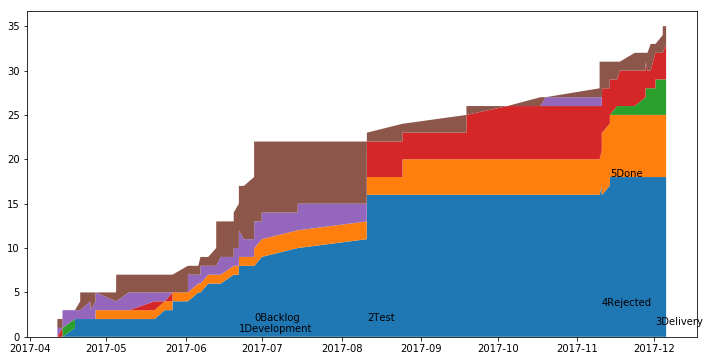

In [670]:
def cfd(transitions):
    y = {}
    x = []
    states = transitions['to'].append(transitions['from']).unique()
    for state in states:    
        if state is not None:
            y[state] = []
            
    for _, transition in transitions.sort_values(by=['ts'], ascending=True).iterrows():   
        if transition['to'] != transition['from']:
            x.append(pd.to_datetime(transition['ts']))
            for state in states:
                if state is not None:
                    last_value = 0 if not y[state] else y[state][-1]
                    if state == transition['from']:
                        y[state].append(last_value - 1)
                    elif state == transition['to']:
                        y[state].append(last_value + 1)
                    else: 
                        y[state].append(last_value)
    y['ts'] = x
    return DataFrame(y)

cfd = cfd(transitions)
fig, ax = plt.subplots()
columns = cfd.drop('ts',1).columns.sort_values(ascending=False)
x = cfd['ts'].values
y = []

area_labels=[]
for column in columns:
    y.append(cfd[column])
    area_labels.append(column)


stack = 0
for index, item in enumerate(y):
    max_index = y[index].argmax()
    date_peak = x[max_index]
    
    quartile = 1/(index+1)
    
    ax.text(date_peak, y[index][max_index]* quartile, area_labels[index])
    stack += y[index][max_index]

ax.stackplot(x, y)


#loc = y2.argmax()
#ax.text(loc, y1[loc] + y2[loc]*0.33, areaLabels[1])

#loc = y3.argmax()
#ax.text(loc, y1[loc] + y2[loc] + y3[loc]*0.75, areaLabels[2]) 

plt.show()


## WIP
* How many issues currently is in board

In [671]:
def wip(transitions):
    current_wip = 0
    wips = []
    for _, transition in transitions.sort_values(by=['key', 'ts'], ascending=True).iterrows():        
        if transition['from'] == '0Backlog' and transition['to'] not in ('5Done', '4Rejected'):
            current_wip+=1
        elif transition['to'] in ('0Backlog', '5Done', '4Rejected') and transition['from'] not in ('0Backlog','5Done', '4Rejected', None):
            current_wip-=1
        wips.append({'ts': pd.to_datetime(transition['ts']), 'wip': current_wip})
    return pd.DataFrame(wips)
wip = wip(transitions).sort_values(by='ts', ascending=True)

(array([ 736420.,  736450.,  736481.,  736511.,  736542.,  736573.,
         736603.,  736634.,  736664.]), <a list of 9 Text xticklabel objects>)

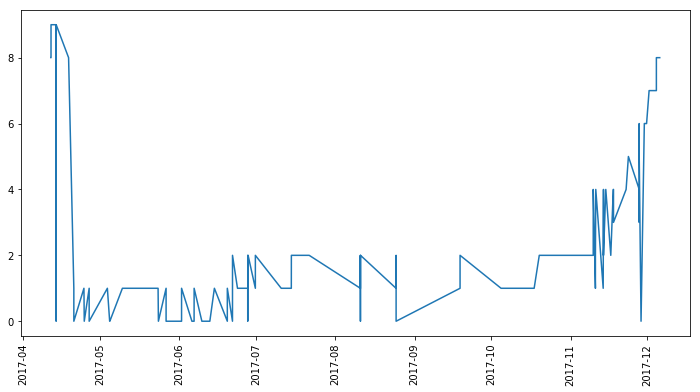

In [672]:
plt.plot(wip['ts'],wip['wip'])
plt.xticks(rotation='vertical')

In [673]:
wip.describe()

,wip
count,136.000000
mean,2.279412
std,2.569598
min,0.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,9.000000
